## MySQL Employees Sample Database
Using the MySQL Employees sample database to practice and learn SQL/MySQL before using Python and R to analyze queried data. Information about the database can be found at [https://dev.mysql.com/doc/employee/en/](https://dev.mysql.com/doc/employee/en/). The database can be downloaded at [https://github.com/datacharmer/test_db](https://github.com/datacharmer/test_db).

### Tools used
- Package dplyr for data manipulation functions such as filter
- Packages tseries and forecast for time series analysis functions
- Package MASS for the Box Cox transformation function boxcox
- Package RMySQL to connect to MySQL database and query
- Package ResourceSelection for Hosmer-Lemeshow Goodness of Fit Test (i.e. is our logistic regression model a good fit)

In [1]:
# options(scipen = 999) Toggle scientific notation off
# Import package dplyr for easier data manipulation
library(dplyr, warn.conflicts = FALSE)

# Change working directory
setwd("C:/Users/Christopher Wong/Desktop/employees/")

# If you do not want to use read.table, you can use 'fread' from the package data.table which reads large files such as .csv much quicker than read.table.
# Just make sure to convert to dataframe.
# Import employee salary data from .csv file used in Tableau
employee_salary <- read.table("employee_salary.csv", header = TRUE, sep = ";")
# Order by emp_no and make YEAR.from_date. a factor
employee_salary <- employee_salary[order(employee_salary$emp_no), ]
employee_salary$YEAR.from_date. <- as.factor(employee_salary$YEAR.from_date.)
# Attach to environment
attach(employee_salary)

### Are there differences in salary between departments? What about between titles?

To test this, we can use a one-way ANOVA test with salary being our dependent variable ("Y") and departments/titles our independent variable ("X"). To use a one-way ANOVA test, we need to satisfy these assumptions:
1. Residuals are normally distributed (or approximately normally distributed) or the distributions within groups are normally distributed
2. Variances of populations are the same
3. Responses are independent and identically distributed (iid)

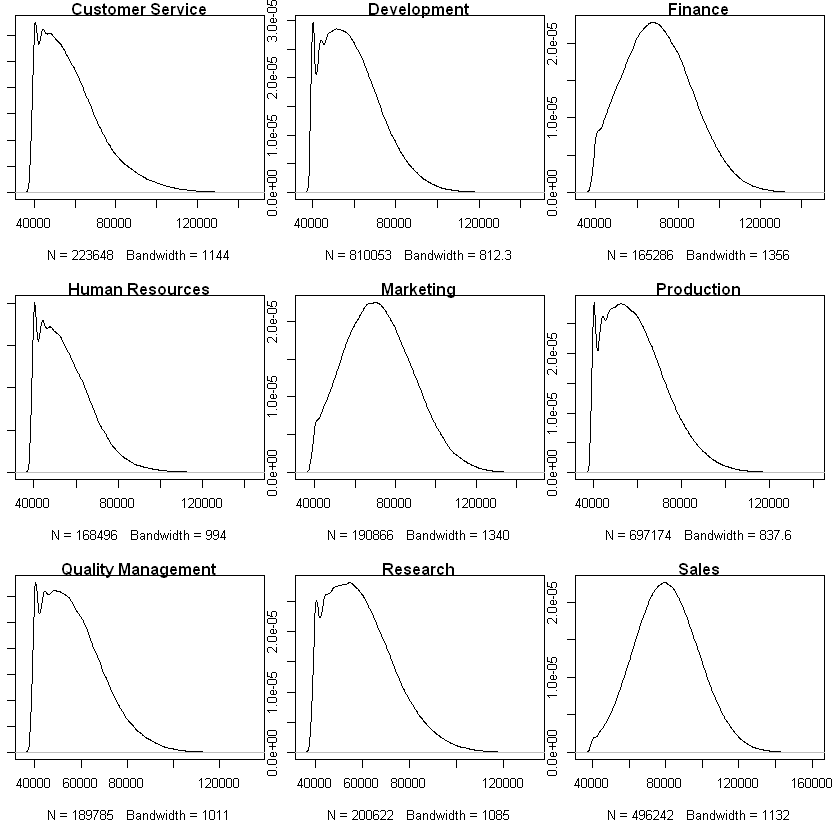

In [6]:
# Change plot settings
par(mfrow = c(3, 3))
par(mar = c(5.1,1,1,1))

### Plot the distributions of salary within groups dept_name
# Plot salary distribution within department
# NOTE: I did not filter salaries by year because from the Tableau section of this project we see salaries increase at the same rate across years
a <- sapply(levels(dept_name), function(x){
  plot(density(filter(employee_salary, dept_name == x)$salary), main = x)
})

We can clearly see the salaries within departments are NOT normally distributed. Thus, we cannot use a parametric one-way ANOVA test. Instead, we can use its nonparametric counterpart: the Kruskal-Wallis H test.

The Kruskal-Wallis H test checks whether samples originate from the same distribution.
- $H_0:$ The samples come from identical populations
- $H_1:$ The samples come from nonidentical populations

In [10]:
# Testing if distributions of salary within departments are identical
kruskal.test(salary~dept_name, data = employee_salary)


	Kruskal-Wallis rank sum test

data:  salary by dept_name
Kruskal-Wallis chi-squared = 666220, df = 8, p-value < 2.2e-16


Our p-value is less than machine precision (2.2e-16) which is essentially 0, so we reject the null hypothesis and conclude that our salaries for different departments come from nonidentical populations. Well, this does not tell us anything we could not have seen from the distributions above, so instead let's use Pairwise Wilcoxon Rank Sum Tests to determine which departments have different distributions.

In [3]:
# Calculating pairwise comparisons
pairwise.wilcox.test(salary, dept_name, data = employee_salary, p.adjust.method = "BH")


	Pairwise comparisons using Wilcoxon rank sum test 

data:  salary and dept_name 

                   Customer Service Development Finance Human Resources
Development        < 2e-16          -           -       -              
Finance            < 2e-16          < 2e-16     -       -              
Human Resources    < 2e-16          < 2e-16     < 2e-16 -              
Marketing          < 2e-16          < 2e-16     < 2e-16 < 2e-16        
Production         < 2e-16          9.5e-10     < 2e-16 < 2e-16        
Quality Management < 2e-16          < 2e-16     < 2e-16 < 2e-16        
Research           < 2e-16          9.4e-06     < 2e-16 < 2e-16        
Sales              < 2e-16          < 2e-16     < 2e-16 < 2e-16        
                   Marketing Production Quality Management Research
Development        -         -          -                  -       
Finance            -         -          -                  -       
Human Resources    -         -          -                  -    

We see that all department pairings EXCEPT Production and Research have significantly different distributions. Let us perform the same analysis using title as a factor now.

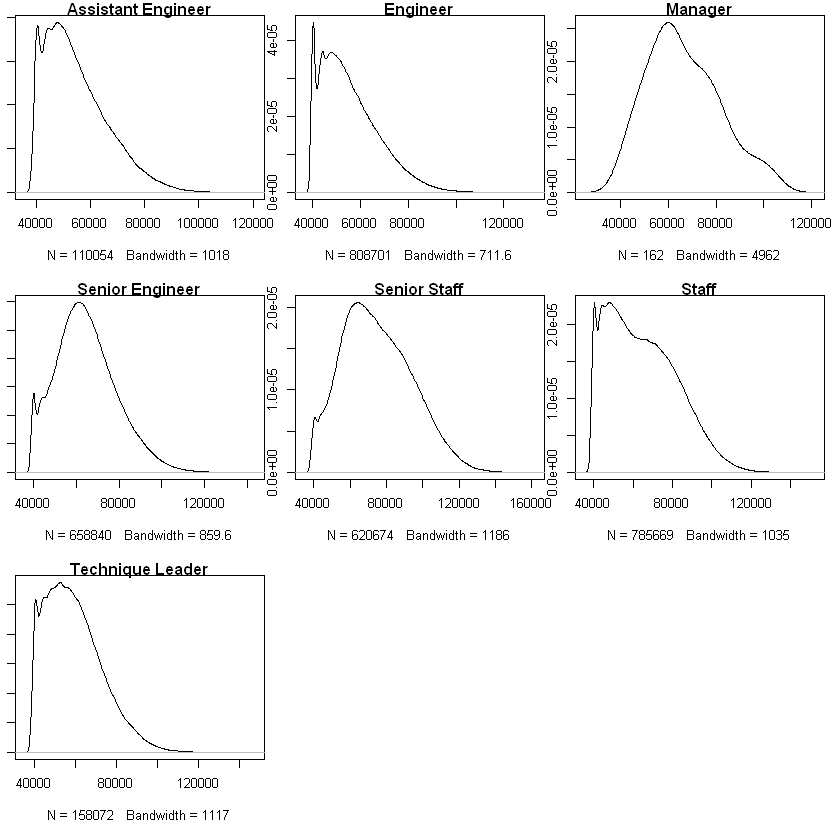

In [8]:
# Change plot settings
par(mfrow = c(3, 3))
par(mar = c(5.1,1,1,1))

### Plot the distributions of salary within groups 'title'
# Plot salary distribution within titles
# NOTE: I did not filter salaries by year because from the Tableau section of this project we see salaries increase at the same rate across years
a <- sapply(levels(title), function(x){
  plot(density(filter(employee_salary, title == x)$salary), main = x)
})

In [9]:
# Testing if distributions of salary within title are identical
kruskal.test(salary~title, data = employee_salary)


	Kruskal-Wallis rank sum test

data:  salary by title
Kruskal-Wallis chi-squared = 478650, df = 6, p-value < 2.2e-16


Our p-value is less than machine precision (2.2e-16) which is essentially 0, so we reject the null hypothesis and conclude that our salaries for different titles come from nonidentical populations. Well, this does not tell us anything we could not have seen from the distributions above, so instead let's use Pairwise Wilcoxon Rank Sum Tests to determine which departments have different distributions.

In [10]:
# Calculating pairwise comparisons
pairwise.wilcox.test(salary, title, data = employee_salary, p.adjust.method = "BH")


	Pairwise comparisons using Wilcoxon rank sum test 

data:  salary and title 

                 Assistant Engineer Engineer Manager Senior Engineer
Engineer         < 2e-16            -        -       -              
Manager          < 2e-16            < 2e-16  -       -              
Senior Engineer  < 2e-16            < 2e-16  0.197   -              
Senior Staff     < 2e-16            < 2e-16  1.5e-08 < 2e-16        
Staff            < 2e-16            < 2e-16  0.081   < 2e-16        
Technique Leader < 2e-16            < 2e-16  6.7e-10 < 2e-16        
                 Senior Staff Staff  
Engineer         -            -      
Manager          -            -      
Senior Engineer  -            -      
Senior Staff     -            -      
Staff            < 2e-16      -      
Technique Leader < 2e-16      < 2e-16

P value adjustment method: BH 

We see that Senior Engineers and Managers have similar salary distributions. This is somewhat expected because senior engineers are valuable assets to a company and thus would be paid similar to other senior roles such as managers.

However, there is one surprising pairing here: Staff and Managers. The test says that their distributions are not significantly different (at $\alpha$ = 0.05). However, we have to consider the sample sizes of our distributions within titles. We have 162 salary data points for managers and hundreds of thousands for other titles. Thus, our test results may not be accurate, and the significance stems from variance within manager salaries.

### Can we predict the budget for the year 2002?

**Warning**: This part is extremely boring and nothing interesting came out of the time series analysis. Our model predicts a flat line, indicating that the company has plateaued and growth is stagnant.

Our data for 2002 is incomplete because the sample database cuts off in the middle of the year. This section is a bit lacking because of the way our database was set up. Employee salaries are stored in one year chunks with their yearly salary and the start and end dates. It is possible to partition the data further into monthly salaries, but that may be extrapolation since we would assume monthly salaries are constant for twelve month (i.e. yearly) periods.

Personally I don't think that partitioning the data further would help because salaries are a set amount for employees throughout the year. It's not like the company stops paying employees because the seasons changed or anything, and we saw from the MySQL/Python part of this project that employees leaving the company are outnumbered by employees joining the company. Thus, I will analyze salary budgets for this company using years as my data points.

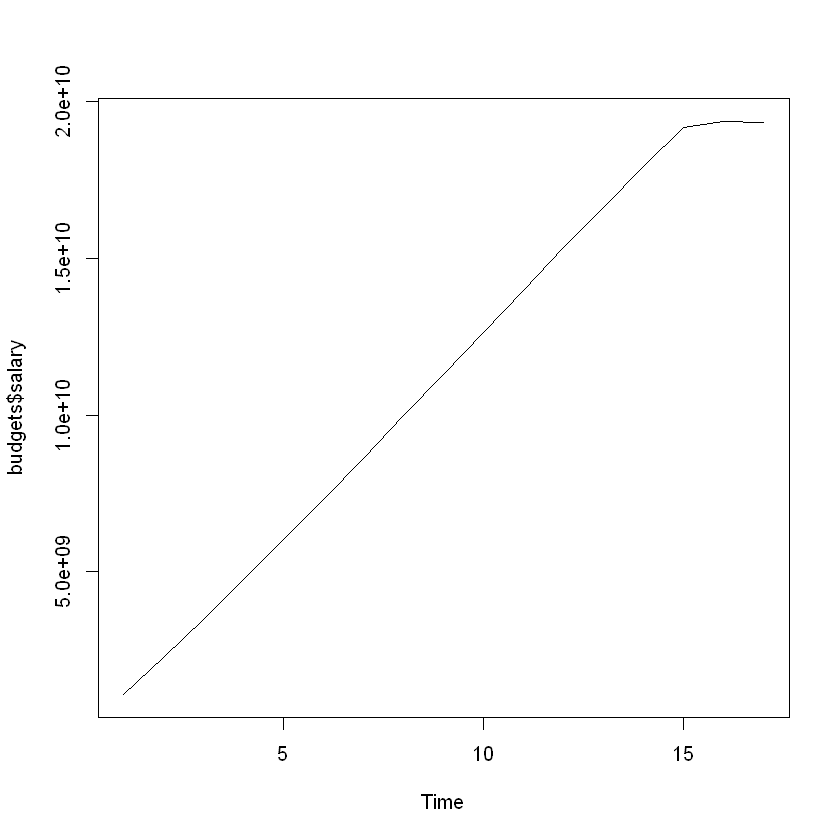

In [6]:
# Import time series packages
library(tseries)

# Get the yearly salary budgets
budgets <- aggregate(salary ~ YEAR.from_date., data = employee_salary, sum)
# Remove 2002 because the data is incomplete
budgets <- budgets[-nrow(budgets), ]

plot.ts(budgets$salary)

There is nothing interesting going on in our data at first glance. There is an obvious increasing trend, but there are no fluctuations or obvious seasonality present. Also, since our periods are years, we only have 17 data points.

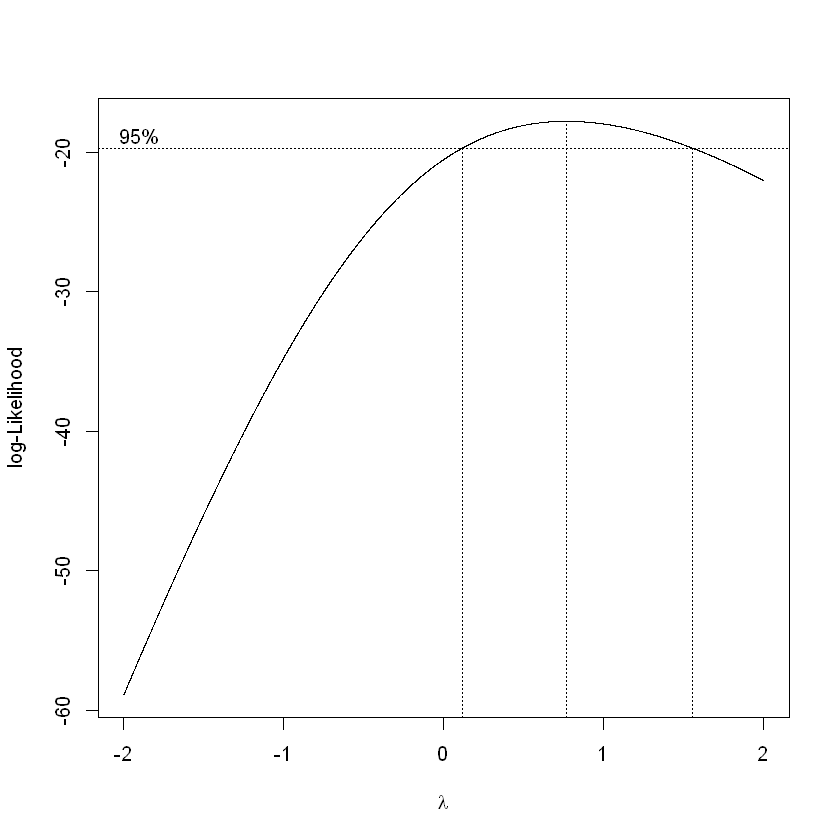

In [4]:
# Test if a transformation is needed to stabilize fluctuations in the data
library(MASS, warn.conflicts = FALSE)
a <- boxcox(budgets$salary~1, lambda = seq(-2, 2, 0.001))

In [5]:
# Lambda = 1, do not have to transform. But only slightly better
a$y[a$x == 0.5]
a$y[a$x == 1]

[1] -18.07543

[1] -17.98126

In [7]:
# Decompose the time series data
decompose(ts(budgets$salary, frequency = 1))

ERROR: Error in decompose(ts(budgets$salary, frequency = 1)): time series has no or less than 2 periods


The decompose function cannot find any components of a time series in our data (trend, seasonal, errors). This is why this section is not interesting.

In [9]:
# Fitting an ARIMA model
mod <- auto.arima(budgets$salary)
mod

Series: budgets$salary 
ARIMA(0,2,0) 

sigma^2 estimated as 7.978e+16:  log likelihood=-313.17
AIC=628.34   AICc=628.65   BIC=629.05

We see that our the best ARIMA model for our data has no autoregressive (AR) or moving average (MA) components. That is, our data points are not dependent on previous data points and there is no smoothing required from a moving average since our data has no fluctuations. The auto.arima function fit a second-order differencing model to our data to obtain a stationary time series.

- $y_t^* = y_t - 2y_{t-1} + y_{t-2}$

To put our model into perspective, a white noise model is given by ARIMA(0,0,0) and a random walk is given by ARIMA(0,1,0). With this in mind, we expect our forecast to be a horizontal line.

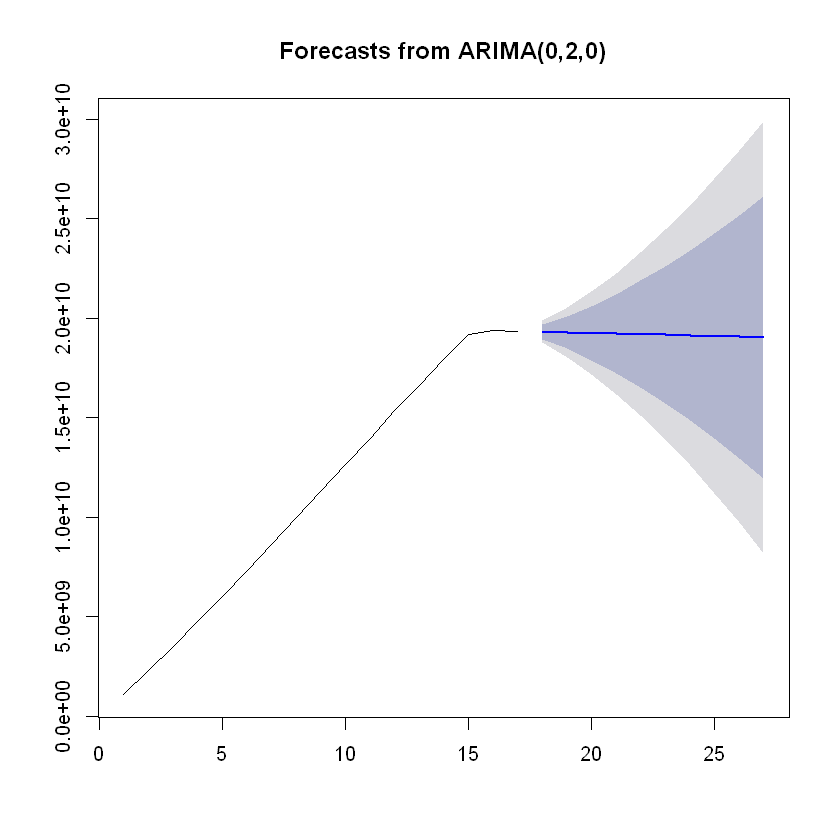

In [10]:
# Forecasting
library(forecast)
fcast <- forecast(mod)
plot(fcast)

### Modeling employee promotions using logistic regression
In the MySQL/Python section of this project, we explored employee promotions visually. Now, we want to try to model them using logistic regression. The variables I chose to model against are gender, dept_name, and title. I leave out days_to_promotion because I created a binary variable promotion_binary based on whether days_to_promotion was a non-null value, and I am using promotion_binary as my response variable.

In [14]:
# options(scipen = 999) Toggle scientific notation off
# Import RMySQL to connect to our database, replace "yourusername" and "yourpassword"
library(RMySQL, warn.conflicts = FALSE)
con <- dbConnect(dbDriver("MySQL"), user = "yourusername", password = "yourpassword", dbname = "employees")

# Promotions model
promotions <- dbGetQuery(con, "SELECT emp_no, gender, dept_name, title, IF (a.days_to_promotion IS NULL, 0, 1) AS promotion_binary
FROM
(SELECT employees.emp_no, employees.gender, departments.dept_name, IF (promotions.hire_title IS NOT NULL, promotions.hire_title, titles.title) AS title, TIMESTAMPDIFF(DAY, promotions.hire_date, promotions.promotion_date) AS days_to_promotion
FROM employees JOIN dept_emp ON employees.emp_no = dept_emp.emp_no JOIN departments ON dept_emp.dept_no = departments.dept_no JOIN titles ON employees.emp_no = titles.emp_no LEFT JOIN promotions ON employees.emp_no = promotions.emp_no
GROUP BY employees.emp_no) AS a;")

We will use stepwise regression to build our logistic regression model.

In [16]:
# Empty and full models
nothing <- glm(promotion_binary~1 - emp_no, data = promotions, family = binomial(link = logit))
full <- glm(promotion_binary~. - emp_no, data = promotions, family = binomial(link = logit))

# Stepwise regression forwards and backwards
forwards <- step(nothing, scope = list(lower = formula(nothing), upper = formula(full)), direction = "forward", trace = FALSE)
backwards <- step(full, scope = list(lower = formula(nothing), upper = formula(full)), direction = "backward", trace = FALSE)

# Same model for forwards and backwards stepwise regression
final.model <- forwards
final.model


Call:  glm(formula = promotion_binary ~ title, family = binomial(link = logit), 
    data = promotions)

Coefficients:
          (Intercept)          titleEngineer           titleManager  
             0.465387              -0.009761              13.100679  
 titleSenior Engineer      titleSenior Staff             titleStaff  
           -10.775904              -9.043976               0.011662  
titleTechnique Leader  
            -9.397864  

Degrees of Freedom: 300023 Total (i.e. Null);  300017 Residual
Null Deviance:	    414700 
Residual Deviance: 304500 	AIC: 304500

Our final model uses all titles at the company except Assistant Engineer. This confirms our visual analysis in the MySQL/Python section that gender does not affect an employee's promotion potential. We also see that departments are the same; an employee's promotion potential does not depend on their gender, age, or department.

Let's now interpret our model and conditional odds ratios.

In [33]:
# Odds ratios
est.coef <- coef(final.model)
est.coef.se <- summary(final.model)$coefficients[, "Std. Error"]
odds <- exp(est.coef[-which(names(est.coef) == "(Intercept)")])
odds

titleEngineer  titleSenior Engineer     titleSenior Staff 
        0.99028686883         0.00002089703         0.00011810028 
           titleStaff titleTechnique Leader 
        1.01173010640         0.00008290097

In [34]:
# Odds ratio confidence intervals
odds.CI <- data.frame(lower = exp(est.coef[-which(names(est.coef) == "(Intercept)")]-1.96*est.coef.se[-which(names(est.coef) == "(Intercept)")]),
                      upper = exp(est.coef[-which(names(est.coef) == "(Intercept)")]+1.96*est.coef.se[-which(names(est.coef) == "(Intercept)")]))
odds.CI

,lower,upper
titleEngineer,9.562291e-01,1.0255576344
titleSenior Engineer,2.947778e-06,0.0001481406
titleSenior Staff,4.912175e-05,0.0002839409
titleStaff,9.769579e-01,1.0477399601
titleTechnique Leader,2.072290e-05,0.0003316414


We see an abnormality in one of our odds ratios: Manager. Its odds ratio confidence interval is also extremely large, indicating that something is amiss in our data for employee promotions with the Manager title.

In [35]:
# Investigate Manager promotions
filter(promotions, title == "Manager")

emp_no,gender,dept_name,title,promotion_binary
110022,M,Marketing,Manager,1
110085,M,Finance,Manager,1
110183,F,Human Resources,Manager,1
110303,F,Production,Manager,1
110344,F,Production,Manager,1
110386,M,Production,Manager,1
110511,M,Development,Manager,1
110725,F,Quality Management,Manager,1
110765,F,Quality Management,Manager,1
110800,F,Quality Management,Manager,1


This is why our Manager variable has such a large odds ratio. All managers in this company have been promoted! On top of that, there are only a handful of managers compared to the number of employees. Thus, we will rerun our model with managers removed.

In [27]:
# Taking out managers
promotions_no_managers <- filter(promotions, title != "Manager")

# Empty and full models
nothing <- glm(promotion_binary~1 - emp_no, data = promotions_no_managers, family = binomial(link = logit))
full <- glm(promotion_binary~. - emp_no, data = promotions_no_managers, family = binomial(link = logit))

# Stepwise regression forwards and backwards
forwards <- step(nothing, scope = list(lower = formula(nothing), upper = formula(full)), direction = "forward", trace = FALSE)
backwards <- step(full, scope = list(lower = formula(nothing), upper = formula(full)), direction = "backward", trace = FALSE)

# Same model for forwards and backwards stepwise regression
final.model <- forwards
final.model


Call:  glm(formula = promotion_binary ~ title, family = binomial(link = logit), 
    data = promotions_no_managers)

Coefficients:
          (Intercept)          titleEngineer   titleSenior Engineer  
             0.465387              -0.009761             -10.775904  
    titleSenior Staff             titleStaff  titleTechnique Leader  
            -9.043976               0.011662              -9.397864  

Degrees of Freedom: 300008 Total (i.e. Null);  300003 Residual
Null Deviance:	    414600 
Residual Deviance: 304500 	AIC: 304500

In [36]:
# Odds ratios
est.coef <- coef(final.model)
est.coef.se <- summary(final.model)$coefficients[, "Std. Error"]
odds <- exp(est.coef[-which(names(est.coef) == "(Intercept)")])
odds

titleEngineer  titleSenior Engineer     titleSenior Staff 
        0.99028686883         0.00002089703         0.00011810028 
           titleStaff titleTechnique Leader 
        1.01173010640         0.00008290097

In [29]:
# Odds ratio confidence intervals
odds.CI <- data.frame(lower = exp(est.coef[-which(names(est.coef) == "(Intercept)")]-1.96*est.coef.se[-which(names(est.coef) == "(Intercept)")]),
                      upper = exp(est.coef[-which(names(est.coef) == "(Intercept)")]+1.96*est.coef.se[-which(names(est.coef) == "(Intercept)")]))
odds.CI

,lower,upper
titleEngineer,0.956229128088,1.0255576344
titleSenior Engineer,0.000002947778,0.0001481406
titleSenior Staff,0.000049121752,0.0002839409
titleStaff,0.976957878089,1.0477399601
titleTechnique Leader,0.000020722902,0.0003316414


We see that the odds ratio confidence intervals for Engineer and Staff both contain 1, so we cannot be confident (at $\alpha$ = 0.05) that having the title of Engineer or Staff improves an employee's odds of being promoted. However, compared to the other titles, the odds are much better. But this can be explained by logical reasoning: senior positions are not likely to be promoted, being the highest positions in this company.

In [37]:
# Checking model fit
library(ResourceSelection)                                      
hoslem.test(promotions_no_managers$promotion_binary, fitted(final.model))


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  promotions_no_managers$promotion_binary, fitted(final.model)
X-squared = 3.1885e-13, df = 8, p-value = 1


**Conclusion**: Our analysis gave us some further insights into employee promotions, but we cannot pinpoint exactly what variables are responsible for them. Our data is insufficient for deeper analysis because we cannot see things such as employee performance metrics.

We could probably test employee days at the company as a variable for promotion, but the problem is how we would handle employees who have never been promoted. Do we keep their days_to_promotion as NULL, or insert an extremely large value like 9999 days but that throws off our data. We also used this variable to create a binary promotion variable that we used as our response variable above, and having the variable as a predictor and response simultaneously seems iffy.

However, it is important to note that this is a (relatively) clean sample database which was made to practice on, so we should not expect to perform any complex delves into the data.